# Regression 

## Data

jax backend gpu


Text(0.5, 1.0, 'Scatter plot of noisy data')

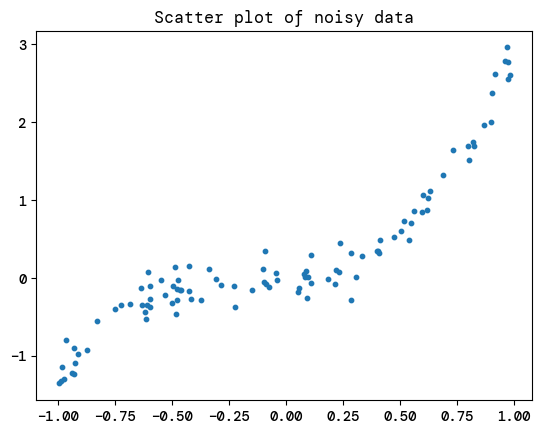

In [81]:
import numpy as onp
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from functools import partial
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))




def FrankeFunction(x,y):
    """
    Franke function
    """
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4



def f(x):
    return 0.2*x + 0.8*x**2 + 2*x**3

key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, shape=(100,), minval=-1, maxval=1)
key, subkey = jax.random.split(key)
y = f(x) + 0.15*jax.random.normal(subkey, shape=(100,))
plt.scatter(x, y, s=10)
plt.title("Scatter plot of noisy data")

## Preprocessing

In [82]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

X = poly.fit_transform(x.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

## useful functions

In [1]:
import ADAMLL as ada

## Results

In [89]:
etas = [ 0.0001, 0.001, 0.01, 0.1 ]
epochs =400
tol = 0.001
gammas = [0.0, 0.1, 0.5, 0.9]
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilon = 1e-8
decay = 0.9
beta1 = 0.9
beta2 = 0.999

def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    return f'Progress: [{arrow}{padding}] {int(fraction*100)}%'




def runGD():
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    scoresRidge = np.zeros((len(etas), len(gammas),len(alphas), epochs))
    for i, eta in enumerate(etas):
        for j, gamma in enumerate(gammas):
            sgd     =  NN(eta=eta, epochs=epochs, tol=tol, gamma=gamma, backwards=gradients, alpha=0) 
            loss, _ = sgd.fit(X_train, y_train, X_test, y_test)
            scoresSgd = scoresSgd.at[i,j,:].set(loss)
            print(progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
            for k, alpha in enumerate(alphas):
                ridgeGd     =  NN(eta=eta, epochs=epochs, tol=tol, alpha=alpha, gamma=gamma, backwards=gradients)
                loss, _ = ridgeGd.fit(X_train, y_train, X_test, y_test)
                scoresRidge = scoresRidge.at[i,j,k,:].set(loss)
    return scoresSgd, scoresRidge



In [90]:
scoresSgd, scoresRidge = runGD()

Training stopped after 399 epochs                           Progress: [>                   ] 0%
Training stopped after 399 epochs                           Progress: [>                   ] 6%
Training stopped after 399 epochs                           Progress: [->                  ] 12%
Training stopped after 399 epochs                           Progress: [-->                 ] 18%
Training stopped after 399 epochs                           Progress: [---->               ] 25%
Training stopped after 399 epochs                           Progress: [----->              ] 31%
Training stopped after 399 epochs                           Progress: [------>             ] 37%
Training stopped after 399 epochs                           Progress: [------->            ] 43%
Training stopped after 399 epochs                           Progress: [--------->          ] 50%
Training stopped after 399 epochs                           Progress: [---------->         ] 56%
Training stopped after 399 epoch

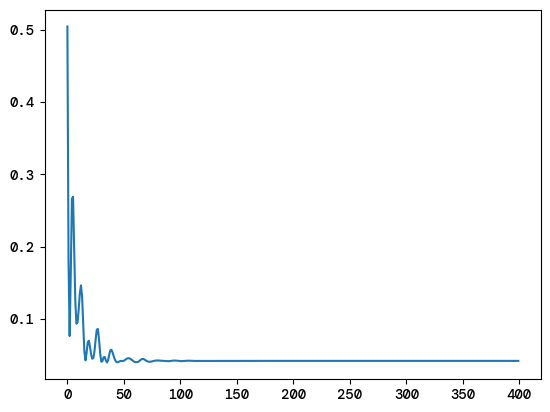

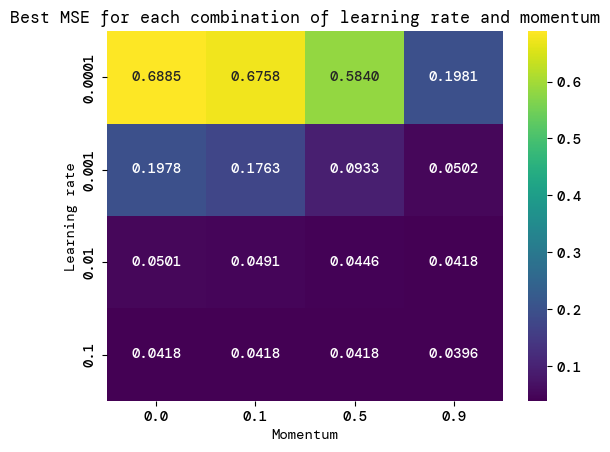

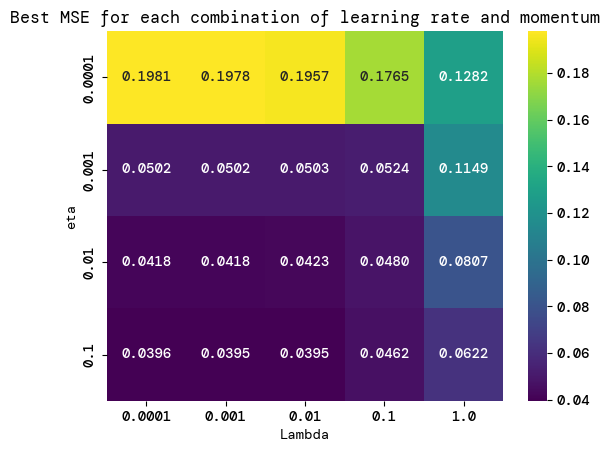

best gamma for each cell ridge
[[0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]]


In [91]:
import seaborn as sns


fig, ax = plt.subplots(1, 1)
ax.plot(scoresSgd[3,3,:])


plt.figure()
ax = sns.heatmap(np.min(scoresSgd,axis=2), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.show()



plt.figure()
ax = sns.heatmap(np.min(scoresRidge,axis=(1,3)), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Lambda")
ax.set_xticklabels(alphas)
ax.set_ylabel("eta")
ax.set_yticklabels(etas)
plt.show()



bestGamma = np.argmin(np.min(scoresRidge,axis=3),axis=1)
print("best gamma for each cell ridge")
print(np.array((gammas,gammas))[0,bestGamma])

In this case havving momentum seems to be beneficial. We maxes out our testing range and found that 0.9 was the best value for momentum.

# Automatic differentiation

Training stopped after 399 epochs                           auto vs manual
auto {'b': Array([0.27468118], dtype=float32), 'w': Array([[0.17716117],
       [0.26869112],
       [0.78947484]], dtype=float32)}
manual {'b': Array([0.27468118], dtype=float32), 'w': Array([[0.17716119],
       [0.26869112],
       [0.78947484]], dtype=float32)}


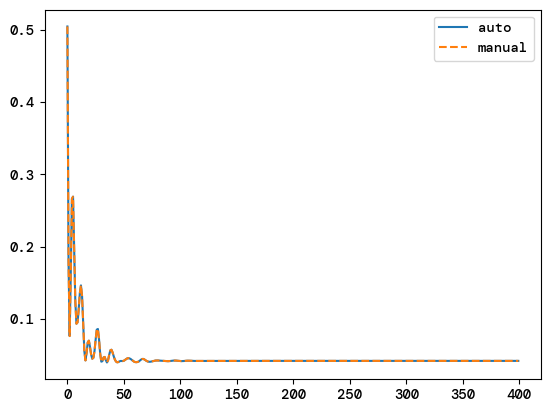

In [92]:
auto = NN(eta=0.1, epochs=epochs, tol=tol, gamma=0.9, backwards=gradients_auto, alpha=0)
manual = NN(eta=0.1, epochs=epochs, tol=tol, gamma=0.9, backwards=gradients, alpha=0)

lossAuto, params_auto = auto.fit(X_train, y_train, X_test, y_test)
lossManual, params = manual.fit(X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(lossAuto,label="auto")
plt.plot(lossManual,"--", label="manual")
plt.legend()
print("auto vs manual")
print("auto",params_auto[0])
print("manual",params[0])

As we can see the analytical and automatic differentiation gives the same results.

## Batch gradient descent / stochastic gradient descent

In [93]:
def runSTG(batch_size=5):
    scoresAdagrad = np.zeros((len(etas), epochs))
    scoresRmsprop = np.zeros((len(etas), epochs))
    scoresAdam = np.zeros((len(etas), epochs))
    for i, eta in enumerate(etas):
        rmsprop = NN(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, gamma=decay, optimizer='rmsprop', backwards=gradients)
        adam = NN(eta=eta, epochs=epochs, tol=tol, beta1=beta1, beta2=beta2, epsilon=epsilon,
                  optimizer='adam', backwards=gradients)
        rms,_ = rmsprop.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        adam_loss, _ =adam.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresRmsprop = scoresRmsprop.at[i,:].set(rms)
        scoresAdam =  scoresAdam.at[i,:].set(adam_loss)
        adagrad = NN(eta=eta, epochs=epochs, tol=tol, backwards=gradients, alpha=0, optimizer='adagrad')
        ada, _ =adagrad.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresAdagrad = scoresAdagrad.at[i,:].set(ada)
        print(progress_bar(i, len(etas)))
            


    return scoresAdagrad, scoresRmsprop, scoresAdam 

In [94]:
ada, rms, adam = runSTG(batch_size=20)

Training stopped after 399 epochs                           Progress: [>                   ] 0%
Training stopped after 399 epochs                           Progress: [---->               ] 25%
Training stopped after 399 epochs                           Progress: [--------->          ] 50%
Training stopped after 399 epochs                           Progress: [-------------->     ] 75%


best eta for adagrad, rmsprop, adam in that order


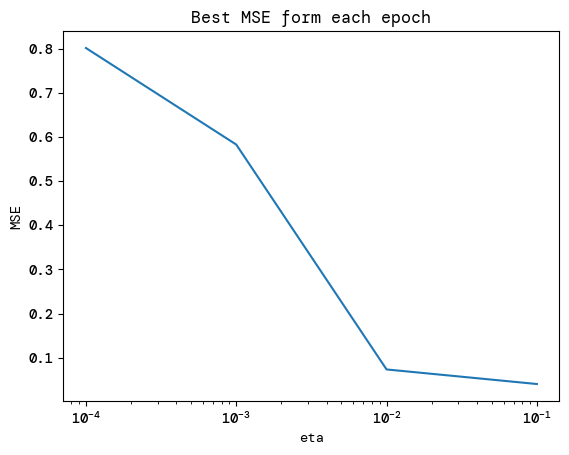

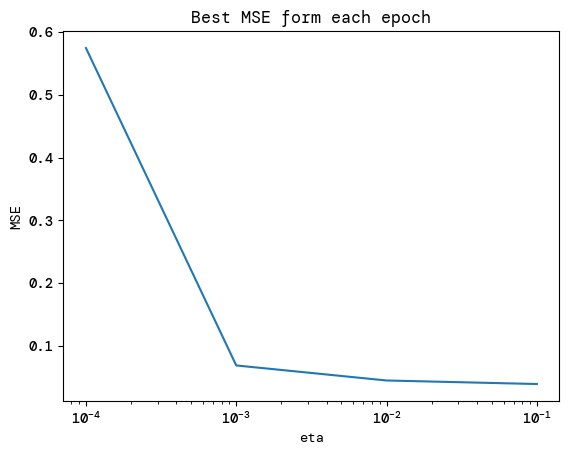

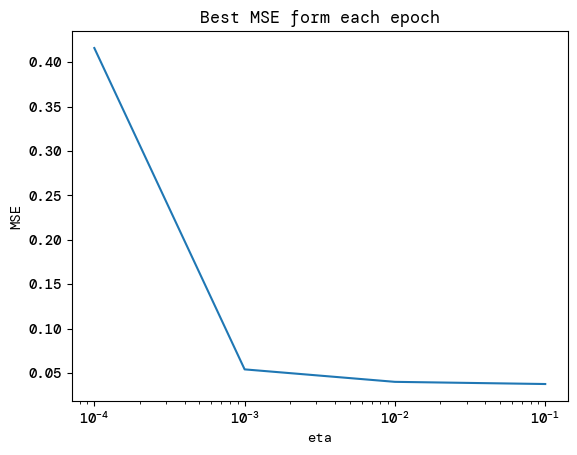

In [97]:

print("best eta for adagrad, rmsprop, adam in that order")

scores_rest = np.array((ada,rms,adam))
for scores in scores_rest:
    scores = np.min(scores,axis=1)
    fig, ax = plt.subplots(1, 1)
    ax.plot(etas,scores)
    ax.set_title("Best MSE form each epoch")
    ax.set_xlabel("eta")
    ax.set_xticks(etas)
    ax.set_xscale('log')
    ax.set_ylabel("MSE")
    plt.show()



In this analysis every model seemed to have converged with the same final MSE, give or take. However 
we see that some models allows us to use a wider range of learning rates. This is especially true for the models with momentum. These new optimizers and auto differentiation is a new tool in our toolbox that we can use to optimize our models.